In [1]:
#importing all required datasets
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sklearn.datasets
import random
import math
from sklearn.utils import shuffle

In [2]:
class ThreeLayerNN:
    
    #class objects initilization
    #NN_config =[a,b,c] a-#no Neurons in input layer,b=# of neurons in hidden layer, c=#of neurons in output layer
    #Theta1~bxa,Theta2~cxb,b1~bx1,b2~cx1
    
    def __init__(self,NN_config,Theta1,Theta2,b1,b2,optimization_method="BGD",lr=0.01,reg_param=0,cost_func="log-loss",decay="const",epsilon=1e-4,noiter=1000,activation="sigmoid",alpha=0.01):
        
        #intilising the configuartion of NN
        self.input_layer=NN_config[0]
        self.hidden_layer=NN_config[1]
        self.output_layer=NN_config[2]
        
        #containers for storing train and test errors
        self.train_error=[]
        self.test_error=[]
        #container for storing the final predicted values
        self.prediction=[]
        
        #values of the z and activations of three layers
        self.a0 = None
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None
        
        #No of iterations elpased so far
        self.epochs=0
        
        #initilising weights and bias
        self.Theta1=Theta1
        self.Theta2=Theta2
        self.b1=b1
        self.b2=b2
        self.unrolled_weights=np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
        
        #intialising deltas for weights and bias
        self.delta_Theta1 = np.zeros(self.Theta1.shape)
        self.delta_Theta2 = np.zeros(self.Theta2.shape)
        self.delta_b1 = np.zeros(self.b1.shape)
        self.delta_b2 = np.zeros(self.b2.shape)
        
        #Initialising Tuning parameter for SGD and MBGD optimizers
        self.decay = decay
        self.decay_rate = 0.01
        
        #Initialising Tuning parameter for SGD optimizer with momentum
        self.beta = 0.9
        
        #Initialising Tuning parameters for Adam optimizer
        self.beta1 = 0.9
        self.beta2 = 0.999
        
        #initilising optimization algorithm (SGD,BGD,MBGD)
        self.optimization_method=optimization_method
        #intialising learning rate(SGD,BGD,MBGD)
        self.lr=lr
        #initilaising regularisation parameter
        self.reg_param=reg_param
        #intialising the type of cost function("log-loss","MSE")
        self.cost_func=cost_func
        #intilising the max number of iterations and threshold (whihever occurs first)to stop optimization algortihms
        self.noiter=noiter
        self.epsilon=epsilon
        #intilising the activation of hidden-layer("tanh","sigmoid","RELU","LeakyRELU","ELU","Softmax")
        self.activation=activation
        #initialsing alpha(used in leaky RELU)
        self.alpha=alpha
        #intialising batchsize (for training)
        self.batch_size = 50
        
    #Defining a function to calculate the cost_function for one row
    def cost(self,y_actual,y_pred,Theta=None):
        m=len(y_actual)
        if Theta is None:
            Theta = self.unrolled_weights
        if(self.cost_func=="log-loss"):
            pad_term=10e-5 #adding this terms to avoid accidently calculating log(0)
            return ((-1/m*(np.sum(y_actual*np.log(y_pred.clip(pad_term)))))+(self.reg_param/(2*m))*(np.sum(Theta**2)))
        elif(self.cost_func=="MSE"):
            loss = (1/2)*(np.square(y_actual-y_pred).mean(axis = 0))
            return (np.sum(loss, axis = 0)+(self.reg_param/(2*m))*(np.sum(Theta**2)))
        
    
    #defining a funciton to calculate the derivative of the cost function
    #NOTE:we generrally use back-prop to calculate derivatives,howver for checking ,we might require this function
    #Please use this function ony for cross-checking,don't put it in the loop,it will take centuries to run!!
    def gradient_checking(self,y_actual,y_pred):
        epsilon=0.01
        self.unrolled_weights=np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
        derivatives=[]
        for i in range(len(self.unrolled_weights)):
            fwd_diff=self.unrolled_weights
            fwd_diff[i]=fwd_diff[i]+epsilon
            bwd_diff=self.unrolled_weights
            bwd_diff[i]=bwd_diff[i]-epsilon
            derivatives.append((self.cost(y_actual,y_pred,fwd_diff)-self.cost(y_actual,y_pred,bwd_diff))/(2*epsilon))
        return derivatives
    
    
    #defining a function to give activations for the hidden layer..Z1=Theta1xX+b1 and Z2=Theta2xa2+b2
    def activation_func(self,z):
        if(self.activation=="sigmoid"):
            return 1/(1+np.exp(-z))
        elif(self.activation=="tanh"):
            return ((2/(1+np.exp(-2*z)))-1)
        elif(self.activation=="RELU"):
            return z.clip(min=0)
        elif(self.activation=="LeakyRELU"):
            return (self.alpha*z.clip(max=0))+z.clip(min=0)
        elif(self.activation=="ELU"):
            return ((self.alpha*np.exp(z.clip(max=0)-1))+z.clip(min=0))
        
    #defining function for derivative of activation functions
    def activation_derivative(self,a):
        if(self.activation=="sigmoid"):
            return np.multiply(a, (1.0 - a))
        elif(self.activation=="tanh"):
            return 1-(a**2)
        elif(self.activation=="RELU"):
            return (np.sign(a)+1)/2
        elif(self.activation=="LeakyRELU"):
            return np.sign(a).clip(self.alpha)
        elif(self.activation=="ELU"):
            return ((self.alpha*np.exp(a.clip(max=0)))-(self.alpha*np.sign(a.clip(min=0)))+a.clip(min=0))
        
        
    #defining the soft-max function for the output layer h(x)
    def softmax(self,z):
        scores=np.exp(z)
        total_score=np.sum(np.exp(z))
        return scores/total_score
    
    
    #Defining functions for FORWARD PROPOGATION
    def forward_propogate(self,x):
        self.a0 = x.copy()
        self.z1 = self.Theta1.dot(self.a0) + self.b1
        self.a1 = self.activation_func(self.z1)
        self.z2 = self.Theta2.dot(self.a1) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2
    
    #Defining function for BACKWARD PROPOGATION(to claculate the derivative of cost function with respect to weights)
    def backward_propogate(self,y_actual,y_hat):
        #calculate delta3
        self.delta3 = np.multiply(-y_actual+y_hat,self.activation_derivative(self.a2))
        #therefore calculate delta2 
        self.delta2 = np.multiply(self.Theta2.T.dot(self.delta3),self.activation_derivative(self.a1))
        #calculate derivatives wrt the weights and bias of the cost function
        self.delta_Theta1 = np.outer(self.delta2,self.a0)
        self.delta_Theta2 = np.outer(self.delta3,self.a1)
        self.delta_b1 = self.delta2
        self.delta_b2 = self.delta3
        return self.delta_Theta1,self.delta_Theta2,self.delta_b1,self.delta_b2
        
        
    #functions for predicting ,GD
    def predict(self,x):
        y_pred=self.forward_propogate(x)
        return np.argmax(y_pred)
    
    #Defining function for plotting the decision boundary,please use this function only once at the last,it is very slow
    def plot_decision_boundary(self,X, y):
        # Set min and max values and give it some padding
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        h = 0.1
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        grid_pts=np.c_[xx.ravel(), yy.ravel()]
        Z=[]
        for x in grid_pts:
            Z.append(self.predict(x))
        Z=np.array(Z)
        Z = Z.reshape(xx.shape)
        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.show()
        

    
        
    def Train_Test_compare(self,x_train,y_train,x_test,y_test,decay=None,batch_size=None,decay_rate=None,optimisation_method=None):
        if(decay!=None):
            self.decay = decay
        if(batch_size!=None):
            self.batch_size = batch_size
        if(decay_rate!=None):
            self.decay_rate=decay_rate
        if(optimisation_method!=None):
            self.optimization_method = optimisation_method
            
        
        #Reshaping y to a position vector
        y_train_pos=[]
        for i in range(len(x_train)):
            a=np.zeros(self.output_layer)
            a[y_train[i]]=1
            y_train_pos.append(a)
        y_train_pos=np.array(y_train_pos)
        
        y_test_pos=[]
        for i in range(len(x_test)):
            a=np.zeros(self.output_layer)
            a[y_test[i]]=1
            y_test_pos.append(a)
        y_test_pos=np.array(y_test_pos)
        
        
###------------------------------------code chunk for batch-gradient Descent-------------------------------------------------###
        if(self.optimization_method=="BGD"):
            self.epochs=0
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                #training with full batch,calculating train MSE
                y_train_cost=0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                for i in range(len(x_train)):
                    y_train_pred = self.forward_propogate(x_train[i])
                    y_train_cost += self.cost(y_train_pos[i],y_train_pred)
                    #checking gradient once
                    #if(epochs==2 and i==2):
                    #    print("calculated gradient is:",self.gradient_checking(y_train_pos[i],y_train_pred))
                    #Finding all deltas and storing them
                    a,b,c,d=self.backward_propogate(y_train_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/len(x_train))
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/len(x_train))+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/len(x_train))+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/len(x_train)
                self.delta_b2 = (del_b2)/len(x_train)
                #updating weights
                self.Theta1 -= self.lr*self.delta_Theta1
                self.Theta2 -= self.lr*self.delta_Theta2
                self.b1 -= self.lr*self.delta_b1
                self.b2 -= self.lr*self.delta_b2
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #cross checking gradient of cost function
                #if(epochs==1):
                #    print("gradient by back-prop is:",np.concatenate((np.ravel(self.delta_Theta1),np.ravel(self.Theta2)),axis=0))
                #If no significant change in test MSE  ...we stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
            
###--------------------------------------------code chunk for stochastic gradient descent------------------------------------###      
        elif(self.optimization_method=="SGD"):
            self.epochs=0
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                #training with random single row from batch,calculating train MSE
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                row=random.randint(0, len(x_train)-1)
                y_train_pred = self.forward_propogate(x_train[row])
                y_train_cost = self.cost(y_train_pos[row],y_train_pred)
                self.train_error.append(y_train_cost)
                del_Theta1,del_Theta2,self.delta_b1,self.delta_b2=self.backward_propogate(y_train_pos[row],y_train_pred)
                self.delta_Theta1 = del_Theta1+self.reg_param*self.Theta1
                self.delta_Theta2 = del_Theta2+self.reg_param*self.Theta2
                #updating learning rate  for different cases
                #no decay
                if(self.decay=="const"):
                    self.lr = self.lr
                #decay is for every iteration
                elif(self.decay=="time-based"):
                    self.lr *= (1. / (1. + self.decay_rate * self.epochs))
                #decay after every 10 iterations
                elif(self.decay=="step-decay"and (self.epochs%10==0)):
                    drop = 0.5
                    epochs_drop = 10.0
                    self.lr *= math.pow(drop,math.floor((1+self.epochs)/epochs_drop))
                #exponential decay
                elif(self.decay=="exponential"):
                    k=0.1
                    self.lr *=  math.exp(-k*self.epochs)
                #updating weights
                self.Theta1 -= self.lr*self.delta_Theta1
                self.Theta2 -= self.lr*self.delta_Theta2
                self.b1 -= self.lr*self.delta_b1
                self.b2 -= self.lr*self.delta_b2
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                 #If no significant change in test MSE  ...we stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
            
            
###----------------------------------------code chunk for mini-batch gradient descent----------------------------------------###

        elif(self.optimization_method=="MBGD"):
            self.epochs=0
            self.batch_size=32
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost += self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                #training with a mini  batch and calculating train MSE
                y_train_cost=0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #decaying learning rate
                #no decay
                if(self.decay=="const"):
                    self.lr = self.lr
                #decay  for every iteration
                elif(self.decay=="time-based"):
                    self.lr *= (1. / (1. + self.decay_rate * self.epochs))
                #decay after every 10 iterations
                elif(self.decay=="step-decay"and (self.epochs%10==0)):
                    drop = 0.5
                    epochs_drop = 10.0
                    self.lr *= math.pow(drop,math.floor((1+self.epochs)/epochs_drop))
                #exponential decay
                elif(self.decay=="exponential"):
                    k=0.1
                    self.lr *=  math.exp(-k*self.epochs)
                #updating weights
                self.Theta1 -= self.lr*self.delta_Theta1
                self.Theta2 -= self.lr*self.delta_Theta2
                self.b1 -= self.lr*self.delta_b1
                self.b2 -= self.lr*self.delta_b2
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #If no significant change in test MSE  ...we stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                

###---------------------------------- code chuunk for SGD with momentum ----------------------------------------------------###         
        elif(self.optimization_method=="SGD with momentum"):
            self.epochs=0
            self.batch_size =36
            #intialising MOVING AVERAGES of partial derivatives with zeros
            self.delta_Theta1_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_MA = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                #training with a mini  batch and calculating train MSE
                y_train_cost=0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the Moving Averages for this iteration
                self.delta_Theta1_MA = (self.beta*self.delta_Theta1_MA)+((1-self.beta)*self.delta_Theta1)
                self.delta_Theta2_MA = (self.beta*self.delta_Theta2_MA)+((1-self.beta)*self.delta_Theta2)
                self.delta_b1_MA = (self.beta*self.delta_b1_MA)+((1-self.beta)*self.delta_b1)
                self.delta_b2_MA = (self.beta*self.delta_b2_MA)+((1-self.beta)*self.delta_b2)
                #updating weights
                self.Theta1 -= self.lr*self.delta_Theta1_MA
                self.Theta2 -= self.lr*self.delta_Theta2_MA
                self.b1 -= self.lr*self.delta_b1_MA
                self.b2 -= self.lr*self.delta_b2_MA
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
            
###------------------------------------ code chunk for Ada Grad optimisation-----------------------------------------------###
        elif(self.optimization_method=="Ada Grad"):
            self.batch_size = 36
            self.lr=0.01
            self.epochs=0
            padding =1e-7
            #intialising CUMULATIVE SQUARES of partial derivatives with zeros
            self.delta_Theta1_CS = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_CS = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_CS = np.zeros(self.delta_b1.shape)
            self.delta_b2_CS = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                y_train_cost = 0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the CUMULATIVE SQUARES for this iteration
                self.delta_Theta1_CS += np.square(self.delta_Theta1)
                self.delta_Theta2_CS += np.square(self.delta_Theta2)
                self.delta_b1_CS += np.square(self.delta_b1)
                self.delta_b2_CS += np.square(self.delta_b2)
                #updating weights
                self.Theta1 -= (self.lr/np.sqrt(self.delta_Theta1_CS+padding))*self.delta_Theta1
                self.Theta2 -= (self.lr/np.sqrt(self.delta_Theta2_CS+padding))*self.delta_Theta2
                self.b1 -= (self.lr/np.sqrt(self.delta_b1_CS+padding))*self.delta_b1
                self.b2 -= (self.lr/np.sqrt(self.delta_b2_CS+padding))*self.delta_b2
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
           
            
###-------------------------------------- code chunk for RMS Prop -----------------------------------------------------------###
        elif(self.optimization_method== "RMS prop"):
            self.lr = 0.001
            self.epochs = 0
            padding =1e-7
            self.batch_size =36
            #intialising CUMULATIVE SQUARES MOVING AVERAGE of partial derivatives with zeros
            self.delta_Theta1_CS_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_CS_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_CS_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_CS_MA = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                y_train_cost = 0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the CUMULATIVE SQUARES MOVING AVERAGE for this iteration
                self.delta_Theta1_CS_MA = (self.beta*self.delta_Theta1_CS_MA)+((1-self.beta)*np.square(self.delta_Theta1))
                self.delta_Theta2_CS_MA = (self.beta*self.delta_Theta2_CS_MA)+((1-self.beta)*np.square(self.delta_Theta2))
                self.delta_b1_CS_MA =  (self.beta*self.delta_b1_CS_MA)+((1-self.beta)*np.square(self.delta_b1))
                self.delta_b2_CS_MA =  (self.beta*self.delta_b2_CS_MA)+((1-self.beta)*np.square(self.delta_b2))
                #updating weights
                self.Theta1 -= (self.lr/np.sqrt(self.delta_Theta1_CS_MA+padding))*self.delta_Theta1
                self.Theta2 -= (self.lr/np.sqrt(self.delta_Theta2_CS_MA+padding))*self.delta_Theta2
                self.b1 -= (self.lr/np.sqrt(self.delta_b1_CS_MA+padding))*self.delta_b1
                self.b2 -= (self.lr/np.sqrt(self.delta_b2_CS_MA+padding))*self.delta_b2
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
            
###------------------------------------- code chunk for  Adam optimizer---------------------------------------------------###
        elif(self.optimization_method== "Adam"):
            self.lr = 0.001
            self.epochs = 0
            padding =1e-8
            self.batch_size =36
            #intialising CUMULATIVE SQUARES MOVING AVERAGES and CUMULATIVE MOVING AVERAGES with zeros
            self.delta_Theta1_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_MA = np.zeros(self.delta_b2.shape)
            self.delta_Theta1_CS_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_CS_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_CS_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_CS_MA = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                y_train_cost = 0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the CUMULATIVE SQUARES MOVING AVERAGE and CUMULATIVE MOVING AVERAGE for this iteration
                self.delta_Theta1_MA = (self.beta1*self.delta_Theta1_MA)+((1-self.beta1)*self.delta_Theta1)
                self.delta_Theta2_MA = (self.beta1*self.delta_Theta2_MA)+((1-self.beta1)*self.delta_Theta2)
                self.delta_b1_MA = (self.beta1*self.delta_b1_MA)+((1-self.beta1)*self.delta_b1)
                self.delta_b2_MA = (self.beta1*self.delta_b2_MA)+((1-self.beta1)*self.delta_b2)
                self.delta_Theta1_CS_MA = (self.beta2*self.delta_Theta1_CS_MA)+((1-self.beta2)*np.square(self.delta_Theta1))
                self.delta_Theta2_CS_MA = (self.beta2*self.delta_Theta2_CS_MA)+((1-self.beta2)*np.square(self.delta_Theta2))
                self.delta_b1_CS_MA = (self.beta2*self.delta_b1_CS_MA)+((1-self.beta2)*np.square(self.delta_b1))
                self.delta_b2_CS_MA = (self.beta2*self.delta_b2_CS_MA)+((1-self.beta2)*np.square(self.delta_b2))
                #calculating corrected MA and CSMA
                self.delta_Theta1_MA_corr = (self.delta_Theta1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_Theta2_MA_corr = (self.delta_Theta2_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b1_MA_corr = (self.delta_b1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b2_MA_corr = (self.delta_b2_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_Theta1_CS_MA_corr = (self.delta_Theta1_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_Theta2_CS_MA_corr = (self.delta_Theta2_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_b1_CS_MA_corr = (self.delta_b1_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_b2_CS_MA_corr = (self.delta_b2_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                #updating weights
                self.Theta1 -= (self.lr/(np.sqrt(self.delta_Theta1_CS_MA_corr)+padding))*self.delta_Theta1_MA_corr
                self.Theta2 -= (self.lr/(np.sqrt(self.delta_Theta2_CS_MA_corr)+padding))*self.delta_Theta2_MA_corr
                self.b1 -= (self.lr/(np.sqrt(self.delta_b1_CS_MA_corr)+padding))*self.delta_b1_MA_corr
                self.b2 -= (self.lr/(np.sqrt(self.delta_b2_CS_MA_corr)+padding))*self.delta_b2_MA_corr
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                

###-------------------------------------- code chunk for AdaMax optimizer ---------------------------------------------------###
        elif(self.optimization_method=="AdaMax"):
            self.lr = 0.002
            self.epochs = 0
            padding =1e-8
            self.batch_size = 36
            #intialising CUMULATIVE SQUARES MOVING AVERAGES and CUMULATIVE MOVING AVERAGES with zeros
            self.delta_Theta1_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_MA = np.zeros(self.delta_b2.shape)
            self.delta_Theta1_CS_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_CS_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_CS_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_CS_MA = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                y_train_cost = 0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the CUMULATIVE SQUARES MOVING AVERAGE and CUMULATIVE MOVING AVERAGE for this iteration
                self.delta_Theta1_MA = (self.beta1*self.delta_Theta1_MA)+((1-self.beta1)*self.delta_Theta1)
                self.delta_Theta2_MA = (self.beta1*self.delta_Theta2_MA)+((1-self.beta1)*self.delta_Theta2)
                self.delta_b1_MA = (self.beta1*self.delta_b1_MA)+((1-self.beta1)*self.delta_b1)
                self.delta_b2_MA = (self.beta1*self.delta_b2_MA)+((1-self.beta1)*self.delta_b2)
                self.delta_Theta1_CS_MA = np.maximum((self.beta2*self.delta_Theta1_CS_MA),np.abs(self.delta_Theta1))
                self.delta_Theta2_CS_MA = np.maximum((self.beta2*self.delta_Theta2_CS_MA),np.abs(self.delta_Theta2))
                self.delta_b1_CS_MA = np.maximum((self.beta2*self.delta_b1_CS_MA),np.abs(self.delta_b1))
                self.delta_b2_CS_MA = np.maximum((self.beta2*self.delta_b2_CS_MA),np.abs(self.delta_b2))
                #calculating corrected MA 
                self.delta_Theta1_MA_corr = (self.delta_Theta1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_Theta2_MA_corr = (self.delta_Theta2_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b1_MA_corr = (self.delta_b1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b2_MA_corr = (self.delta_b2_MA)/(1-math.pow(self.beta1,self.epochs))
                #updating weights
                self.Theta1 -= (self.lr/(self.delta_Theta1_CS_MA))*self.delta_Theta1_MA_corr
                self.Theta2 -= (self.lr/(self.delta_Theta2_CS_MA))*self.delta_Theta2_MA_corr
                self.b1 -= (self.lr/(self.delta_b1_CS_MA))*self.delta_b1_MA_corr
                self.b2 -= (self.lr/(self.delta_b2_CS_MA))*self.delta_b2_MA_corr
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
                
            
###---------------------------------------code chunk for Nadam optimizer---------------------------------------------------###
        elif(self.optimization_method=="Nadam"):
            self.lr = 0.002
            padding = 10e-7
            self.batch_size =36
            #intialising CUMULATIVE SQUARES MOVING AVERAGES and CUMULATIVE MOVING AVERAGES with zeros
            self.delta_Theta1_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_MA = np.zeros(self.delta_b2.shape)
            self.delta_Theta1_CS_MA = np.zeros(self.delta_Theta1.shape)
            self.delta_Theta2_CS_MA = np.zeros(self.delta_Theta2.shape)
            self.delta_b1_CS_MA = np.zeros(self.delta_b1.shape)
            self.delta_b2_CS_MA = np.zeros(self.delta_b2.shape)
            while(self.epochs<self.noiter):
                self.epochs+=1
                #calculating the test MSE
                y_test_cost=0
                for i in range(len(x_test)):
                    y_test_pred = self.forward_propogate(x_test[i])
                    y_test_cost+= self.cost(y_test_pos[i],y_test_pred)
                self.test_error.append(y_test_cost/len(x_test))
                y_train_cost = 0
                del_Theta1=np.zeros(self.delta_Theta1.shape)
                del_Theta2=np.zeros(self.delta_Theta2.shape)
                del_b1=np.zeros(self.delta_b1.shape)
                del_b2=np.zeros(self.delta_b2.shape)
                #choosing a random batch
                x_train,y_train_pos = shuffle(x_train,y_train_pos)
                x_batch = x_train[:self.batch_size,:]
                y_batch_pos = y_train_pos[:self.batch_size]
                for i in range(self.batch_size):
                    y_train_pred = self.forward_propogate(x_batch[i])
                    y_train_cost += self.cost(y_batch_pos[i],y_train_pred)
                    a,b,c,d=self.backward_propogate(y_batch_pos[i],y_train_pred)
                    del_Theta1 += a
                    del_Theta2 += b
                    del_b1 += c
                    del_b2 += d
                self.train_error.append(y_train_cost/self.batch_size)
                #finding average of deltas
                self.delta_Theta1 = ((del_Theta1)/self.batch_size)+self.reg_param*self.Theta1 
                self.delta_Theta2 = (del_Theta2/self.batch_size)+self.reg_param*self.Theta2
                self.delta_b1 = (del_b1)/self.batch_size
                self.delta_b2 = (del_b2)/self.batch_size
                #calculating the CUMULATIVE SQUARES MOVING AVERAGE and CUMULATIVE MOVING AVERAGE for this iteration
                self.delta_Theta1_MA = (self.beta1*self.delta_Theta1_MA)+((1-self.beta1)*self.delta_Theta1)
                self.delta_Theta2_MA = (self.beta1*self.delta_Theta2_MA)+((1-self.beta1)*self.delta_Theta2)
                self.delta_b1_MA = (self.beta1*self.delta_b1_MA)+((1-self.beta1)*self.delta_b1)
                self.delta_b2_MA = (self.beta1*self.delta_b2_MA)+((1-self.beta1)*self.delta_b2)
                self.delta_Theta1_CS_MA = (self.beta2*self.delta_Theta1_CS_MA)+((1-self.beta2)*np.square(self.delta_Theta1))
                self.delta_Theta2_CS_MA = (self.beta2*self.delta_Theta2_CS_MA)+((1-self.beta2)*np.square(self.delta_Theta2))
                self.delta_b1_CS_MA = (self.beta2*self.delta_b1_CS_MA)+((1-self.beta2)*np.square(self.delta_b1))
                self.delta_b2_CS_MA = (self.beta2*self.delta_b2_CS_MA)+((1-self.beta2)*np.square(self.delta_b2))
                #calculating corrected MA and CSMA
                self.delta_Theta1_MA_corr = (self.delta_Theta1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_Theta2_MA_corr = (self.delta_Theta2_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b1_MA_corr = (self.delta_b1_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_b2_MA_corr = (self.delta_b2_MA)/(1-math.pow(self.beta1,self.epochs))
                self.delta_Theta1_CS_MA_corr = (self.delta_Theta1_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_Theta2_CS_MA_corr = (self.delta_Theta2_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_b1_CS_MA_corr = (self.delta_b1_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                self.delta_b2_CS_MA_corr = (self.delta_b2_CS_MA)/(1-math.pow(self.beta2,self.epochs))
                #updating weights
                self.Theta1 -= (self.lr/(np.sqrt(self.delta_Theta1_CS_MA_corr)+padding))*((self.beta1*self.delta_Theta1_MA_corr)+(((1-self.beta1)/(1-math.pow(self.beta1,self.epochs)))*self.delta_Theta1))
                self.Theta2 -= (self.lr/(np.sqrt(self.delta_Theta2_CS_MA_corr)+padding))*((self.beta1*self.delta_Theta2_MA_corr)+(((1-self.beta1)/(1-math.pow(self.beta1,self.epochs)))*self.delta_Theta2))
                self.b1 -= (self.lr/(np.sqrt(self.delta_b1_CS_MA_corr)+padding))*((self.beta1*self.delta_b1_MA_corr)+(((1-self.beta1)/(1-math.pow(self.beta1,self.epochs)))*self.delta_b1))
                self.b2 -= (self.lr/(np.sqrt(self.delta_b2_CS_MA_corr)+padding))*((self.beta1*self.delta_b2_MA_corr)+(((1-self.beta1)/(1-math.pow(self.beta1,self.epochs)))*self.delta_b2))
                self.unrolled_weights = np.concatenate((np.ravel(self.Theta1),np.ravel(self.Theta2)),axis=0)
                #Doesn't improve..stop
                if(self.epochs>5):
                    if(np.abs(self.test_error[self.epochs-1]-self.test_error[self.epochs-2])<self.epsilon):
                        break
        print("The number of iterations required for convergence is:", self.epochs)
        print("The Training-loss at final epoch is:",self.train_error[-1])
        print("The Testing-loss at final epoch is:",self.test_error[-1])
      
    #function for plotting loss at every iteration
    def convergence_curve(self):
        plt.plot(range(len(self.train_error)),self.train_error,label="train-error")
        plt.plot(range(len(self.test_error)),self.test_error,label="test-error")
        plt.xlabel('no of iterations')
        plt.title('train error and test error')
        plt.legend(loc="upper right")
        plt.show() 
        
    #function  for calculating precision,recall,F-1 score (in case of a binary classification)  
    def performance_measures(self,x_test,y_test):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(len(x_test)):
            m=self.predict(x_test[i])
            self.prediction.append(m)
            if(m==y_test[i]==1):
                TP +=1
            elif( m==1 and y_test[i]!=m):
                FP +=1
            elif(m==y_test[i]==0):
                TN +=1
            elif(m==0 and y_test[i]!=m):
                FN +=1
        self.precision = (TP)/(TP+FP)
        self.recall = (TP)/(TP+FN)
        self.F1 = (2*self.precision*self.recall)/(self.precision+self.recall)
        print("PRECISION:",self.precision)
        print("RECALL:",self.recall)
        print("F1-SCORE:",self.F1)
        
        #confusion matrix (in case of multi-class classification)
    def confusion_matrix(self,x_test,y_test):
        self.confusion_mat = np.zeros((self.output_layer,self.output_layer))
        for i in range(len(x_test)):
            m = self.predict(x_test[i])
            self.confusion_mat[y_test[i]][m] +=1
        #image rep of confusion matrix
        print("CONFUSION MATRIX:")
        plt.matshow(self.confusion_mat, cmap=plt.cm.gray) 
        plt.show()
        
        

        
        

# DATASET-1 BINARY CLASSIFICATION
## Mammogram Predict whether a tumor is benign or malignant

### DESCRIPTION:
#### Instances: 961
#### Attributes: 6
#### Malignant:1 and Benign:0

In [16]:
Tumor =pd.read_csv('mammogram_dataset.csv')
Tumor.shape

(961, 6)

In [17]:
Tumor = Tumor.replace(-100000, np.nan)
print(Tumor.isna().any())
Tumor.dropna(inplace = True)
print(Tumor.isna().any())
Tumor.shape

BI_RADS_assessment     True
age                    True
shape                  True
margin                 True
density                True
severity              False
dtype: bool
BI_RADS_assessment    False
age                   False
shape                 False
margin                False
density               False
severity              False
dtype: bool


(830, 6)

In [18]:
Tumor.head(2)

,BI_RADS_assessment,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
2,5.0,58.0,4.0,5.0,3.0,1


In [19]:
mean_age = Tumor.age.mean()
min_age = Tumor.age.min()
max_age = Tumor.age.max()
Tumor['age'] = Tumor['age'].apply(lambda x: (x - mean_age ) / (max_age -min_age ))

In [20]:
Tumor.head(2)

,BI_RADS_assessment,age,shape,margin,density,severity
0,5.0,0.143821,3.0,5.0,3.0,1
2,5.0,0.028437,4.0,5.0,3.0,1


In [21]:
from sklearn.model_selection import train_test_split
X =  Tumor.drop('severity', axis=1)
y =  Tumor['severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
Tumor_train= X_train.to_numpy()
Tumor_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### MODEL :1 
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : VANILLA BATCH GD OPTIMISATION

In [33]:
NN_config =[5,10,2]
np.random.seed(10)
W1 = np.random.rand(10,5)
W2 = np.random.rand(2,10)
b1 = np.random.rand(10)
b2 = np.random.rand(2)

In [10]:
model=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-8)
model.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,optimisation_method="BGD")

The number of iterations required for convergence is: 2000
The Training-loss at final epoch is: 0.33695409016563577
The Testing-loss at final epoch is: 0.33544395577344516


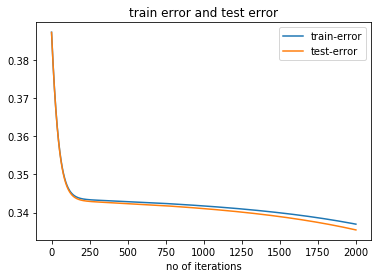

In [11]:
model.convergence_curve()

In [12]:
model.performance_measures(Tumor_test,y_test)

PRECISION: 0.7948717948717948
RECALL: 0.768595041322314
F1-SCORE: 0.7815126050420167


### MODEL :2
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : VANILLA STOCHASTIC GD OPTIMISATION
- decay type : NO DECAY(constant learning rate)

The number of iterations required for convergence is: 2000
The Training-loss at final epoch is: 0.3341663257659166
The Testing-loss at final epoch is: 0.3090599664460922


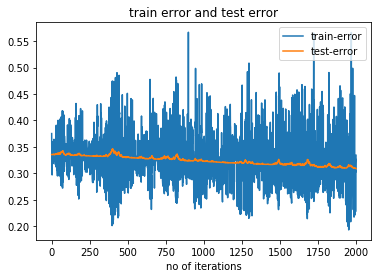

PRECISION: 0.7611940298507462
RECALL: 0.8429752066115702
F1-SCORE: 0.7999999999999999


In [13]:
model2=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-8)
model2.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,optimisation_method="SGD")
model2.convergence_curve()
model2.performance_measures(Tumor_test,y_test)

### MODEL :3
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : VANILLA STOCHASTIC GD OPTIMISATION
- decay type : time-based
- decay rate :0.1

The number of iterations required for convergence is: 23
The Training-loss at final epoch is: 0.2645051790935928
The Testing-loss at final epoch is: 0.3107784772857428


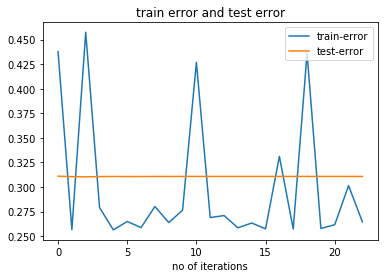

PRECISION: 0.7291666666666666
RECALL: 0.8677685950413223
F1-SCORE: 0.7924528301886793


In [143]:
model3=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-10)
model3.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,decay="time-based",optimisation_method="SGD",decay_rate=0.1)
model3.convergence_curve()
model3.performance_measures(Tumor_test,y_test)

### MODEL :4
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : VANILLA STOCHASTIC GD OPTIMISATION
- decay type : step-wise
- decay rate :0.1

The number of iterations required for convergence is: 71
The Training-loss at final epoch is: 0.2444082078521082
The Testing-loss at final epoch is: 0.3005646685193747


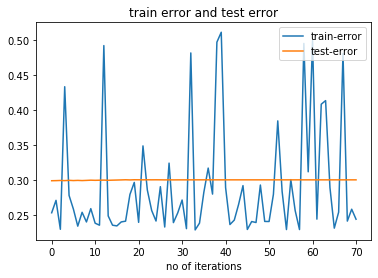

PRECISION: 0.72
RECALL: 0.8925619834710744
F1-SCORE: 0.7970479704797049


In [149]:
model=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-10)
model.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,decay="step-decay",optimisation_method="SGD",decay_rate=0.1)
model.convergence_curve()
model.performance_measures(Tumor_test,y_test)

### MODEL :5
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : VANILLA STOCHASTIC GD OPTIMISATION
- decay type : exponential
- decay rate :0.1

The number of iterations required for convergence is: 18
The Training-loss at final epoch is: 0.2424039610149515
The Testing-loss at final epoch is: 0.2995368952895099


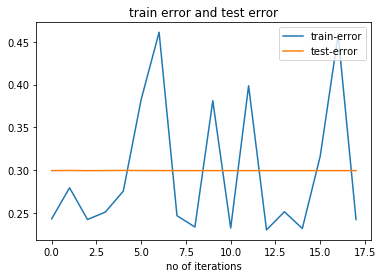

PRECISION: 0.7375886524822695
RECALL: 0.859504132231405
F1-SCORE: 0.7938931297709924


In [154]:
model=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-10)
model.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,decay="exponential",optimisation_method="SGD",decay_rate=0.1)
model.convergence_curve()
model.performance_measures(Tumor_test,y_test)

### MODEL :6
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : MINI-BATCH GD OPTIMISATION
- decay type : constant

The number of iterations required for convergence is: 2000
The Training-loss at final epoch is: 0.30134722451673246
The Testing-loss at final epoch is: 0.279797476674871


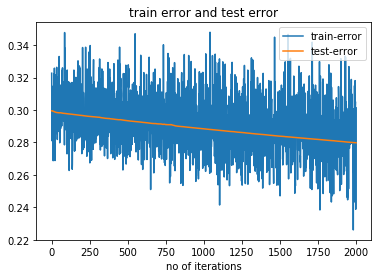

PRECISION: 0.7536231884057971
RECALL: 0.859504132231405
F1-SCORE: 0.803088803088803


In [155]:
model6=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-6)
model6.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,optimisation_method="MBGD")
model6.convergence_curve()
model6.performance_measures(Tumor_test,y_test)

### MODEL :7
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :  MINI-BATCH GD OPTIMISATION
- decay type : time-based
- decay rate :0.1

The number of iterations required for convergence is: 20
The Training-loss at final epoch is: 0.2588751956536041
The Testing-loss at final epoch is: 0.27976436693884704


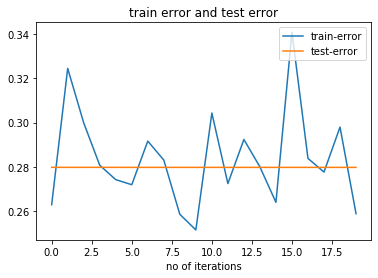

PRECISION: 0.7536231884057971
RECALL: 0.859504132231405
F1-SCORE: 0.803088803088803


In [156]:
model=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-10)
model.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,decay="time-based",optimisation_method="MBGD",decay_rate=0.1)
model.convergence_curve()
model.performance_measures(Tumor_test,y_test)

### MODEL :8
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :  MINI-BATCH GD OPTIMISATION
- decay type : step-wise
- decay rate :0.1

The number of iterations required for convergence is: 2000
The Training-loss at final epoch is: 0.2636667088327622
The Testing-loss at final epoch is: 0.26711333826943046


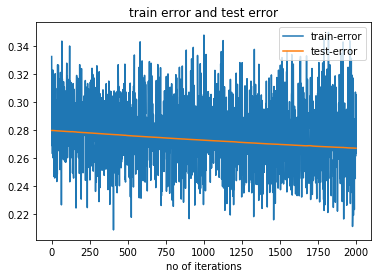

PRECISION: 0.7553956834532374
RECALL: 0.8677685950413223
F1-SCORE: 0.8076923076923077


In [157]:
model=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-10)
model.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,decay="step-wise",optimisation_method="MBGD",decay_rate=0.1)
model.convergence_curve()
model.performance_measures(Tumor_test,y_test)

### MODEL :9
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :  MINI-BATCH GD OPTIMISATION
- decay type : exponential
- decay rate :0.1

The number of iterations required for convergence is: 17
The Training-loss at final epoch is: 0.24726160203697495
The Testing-loss at final epoch is: 0.26719428077808205


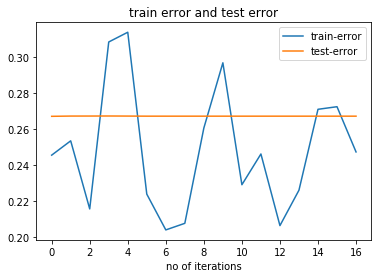

PRECISION: 0.7046979865771812
RECALL: 0.8677685950413223
F1-SCORE: 0.7777777777777777


In [49]:
model9=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-10)
model9.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,decay="exponential",optimisation_method="MBGD",decay_rate=0.1)
model9.convergence_curve()
model9.performance_measures(Tumor_test,y_test)

### MODEL :10
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :  SGD WITH MOMENTUM
- beta = 0.9

The number of iterations required for convergence is: 303
The Training-loss at final epoch is: 0.3377894575289418
The Testing-loss at final epoch is: 0.3430744095331266


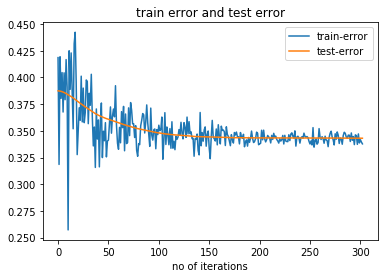

In [26]:
model10=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-7)
model10.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,optimisation_method="SGD with momentum")
model10.convergence_curve()

### MODEL :11
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :   Ada Grad 

The number of iterations required for convergence is: 106
The Training-loss at final epoch is: 0.31473506907073895
The Testing-loss at final epoch is: 0.31769949695960226


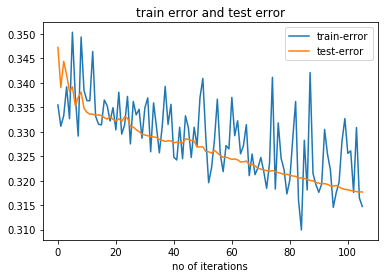

PRECISION: 0.7236842105263158
RECALL: 0.9090909090909091
F1-SCORE: 0.8058608058608059


In [120]:
model11=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-6)
model11.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,optimisation_method="Ada Grad")
model11.convergence_curve()
model11.performance_measures(Tumor_test,y_test)

### MODEL :12
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :   RMS prop
- beta = 0.9

The number of iterations required for convergence is: 1979
The Training-loss at final epoch is: 0.17747901276778202
The Testing-loss at final epoch is: 0.23606473400934622


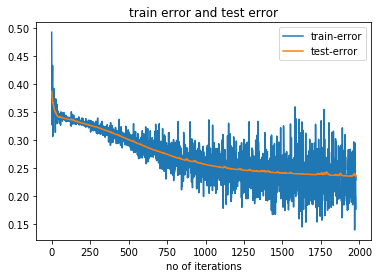

PRECISION: 0.7555555555555555
RECALL: 0.8429752066115702
F1-SCORE: 0.796875


In [145]:
model12=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-7)
model12.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,optimisation_method="RMS prop")
model12.convergence_curve()
model12.performance_measures(Tumor_test,y_test)

### MODEL :13
### DESCRIPTION :
- LEARNING RATE =0.001
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :   Adam
- beta1 = 0.9
- beta2 = 0.999

The number of iterations required for convergence is: 790
The Training-loss at final epoch is: 0.28968986832198595
The Testing-loss at final epoch is: 0.24760958688535914


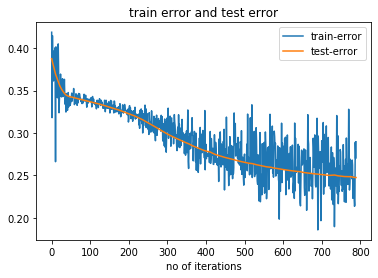

PRECISION: 0.7518248175182481
RECALL: 0.8512396694214877
F1-SCORE: 0.7984496124031008


In [28]:
model13=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-6)
model13.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,optimisation_method="Adam")
model13.convergence_curve()
model13.performance_measures(Tumor_test,y_test)

### MODEL :14
### DESCRIPTION :
- LEARNING RATE =0.001
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :  Nadam
- beta1 = 0.9
- beta2 = 0.999

The number of iterations required for convergence is: 1226
The Training-loss at final epoch is: 0.16149911327838723
The Testing-loss at final epoch is: 0.21841770065711028


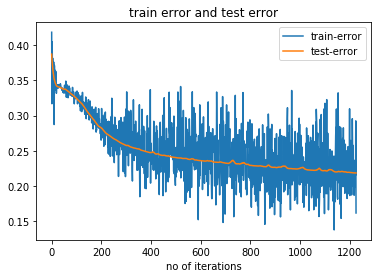

PRECISION: 0.7664233576642335
RECALL: 0.8677685950413223
F1-SCORE: 0.813953488372093


In [30]:
model14=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-7)
model14.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,optimisation_method="Nadam")
model14.convergence_curve()
model14.performance_measures(Tumor_test,y_test)

### MODEL :15
### DESCRIPTION :
- LEARNING RATE =0.001
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :  AdaMax
- beta1 = 0.9
- beta2 = 0.999

The number of iterations required for convergence is: 833
The Training-loss at final epoch is: 0.21559535428779394
The Testing-loss at final epoch is: 0.2568394439705559


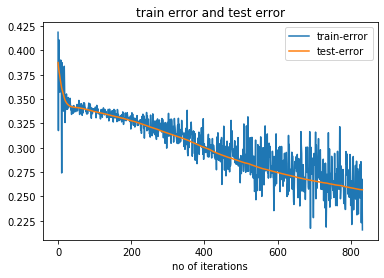

In [34]:
model14=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-5)
model14.Train_Test_compare(Tumor_train,y_train,Tumor_test,y_test,optimisation_method="AdaMax")
model14.convergence_curve()

# ADAgrad CONVERGES IN JUST 16 ITERATIONS!!!!!


![title](top-performer.jpg)

# DATASET-2 BINARY CLASSIFICATION
## Predict if patient from the state of Andhra Pradesh has Liver Disease

### DESCRIPTION:
#### Instances: 583
#### Attributes: 11
#### Predictor Class: 1 if patient has Liver Disease and 2 if they do not

In [41]:
Liver_dis =pd.read_csv('indian_liver_patient_dataset.csv')
Liver_dis.shape

(583, 11)

In [42]:
Liver_dis = Liver_dis.replace(-100000, np.nan)
Liver_dis.dropna(inplace = True)
Liver_dis.shape

(579, 11)

In [43]:
dictionary ={"Male":1,"Female":0}
Liver_dis['gender']=Liver_dis['gender'].map(dictionary)
dictionary1 ={1:1,2:0}
Liver_dis['class']=Liver_dis['class'].map(dictionary1)
to_normalise = ["age","alkphos","sgpt","sgot"]
for i in to_normalise:
    mean = Liver_dis[i].mean()
    mini = Liver_dis[i].min()
    maxi = Liver_dis[i].max()
    Liver_dis[i] = Liver_dis[i].apply(lambda x: (x - mean ) / (maxi -mini ))
    

In [44]:
Liver_dis.head(2)

,age,gender,TB,DB,alkphos,sgpt,sgot,TP,ALB,A_G,class
0,0.235089,0,0.7,0.1,-0.050985,-0.032727,-0.018787,6.8,3.3,0.90,1
1,0.200205,1,10.9,5.5,0.199137,-0.008606,-0.002117,7.5,3.2,0.74,1


In [45]:
from sklearn.model_selection import train_test_split
X =  Liver_dis.drop('class', axis=1)
y =  Liver_dis['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
Liver_train= X_train.to_numpy()
Liver_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### MODEL :1 
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : VANILLA BATCH GD OPTIMISATION

In [63]:
NN_config =[10,4,2]
np.random.seed(10)
W1 = np.random.rand(4,10)
W2 = np.random.rand(2,4)
b1 = np.random.rand(4)
b2 = np.random.rand(2)

The number of iterations required for convergence is: 692
The Training-loss at final epoch is: 0.29843256463269274
The Testing-loss at final epoch is: 0.29989628511062133


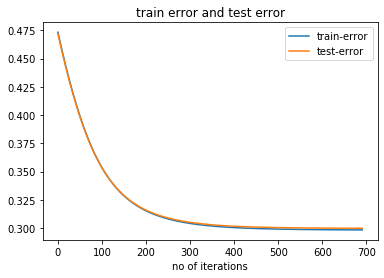

PRECISION: 0.7126436781609196
RECALL: 1.0
F1-SCORE: 0.8322147651006712


In [69]:
model=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-6)
model.Train_Test_compare(Liver_train,y_train,Liver_test,y_test,optimisation_method="BGD")
model.convergence_curve()
model.performance_measures(Liver_test,y_test)

### MODEL :2
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : VANILLA STOCHASTIC GD OPTIMISATION
- decay type : NO DECAY(constant learning rate)

The number of iterations required for convergence is: 798
The Training-loss at final epoch is: 0.6248029772093645
The Testing-loss at final epoch is: 0.2998723691198926


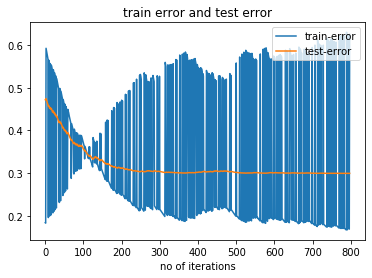

PRECISION: 0.7126436781609196
RECALL: 1.0
F1-SCORE: 0.8322147651006712


In [60]:
model2=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-6)
model2.Train_Test_compare(Liver_train,y_train,Liver_test,y_test,optimisation_method="SGD")
model2.convergence_curve()
model2.performance_measures(Liver_test,y_test)

### MODEL :3
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : VANILLA STOCHASTIC GD OPTIMISATION
- decay type : time-based
- decay rate :0.1

The number of iterations required for convergence is: 25
The Training-loss at final epoch is: 0.5833010392584042
The Testing-loss at final epoch is: 0.46926964068519844


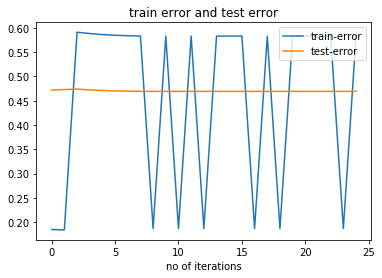

In [64]:
model3=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-10)
model3.Train_Test_compare(Liver_train,y_train,Liver_test,y_test,decay="time-based",optimisation_method="SGD",decay_rate=0.1)
model3.convergence_curve()

### MODEL :4
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : VANILLA STOCHASTIC GD OPTIMISATION
- decay type : step-wise
- decay rate :0.1

The number of iterations required for convergence is: 13
The Training-loss at final epoch is: 0.16895051191775132
The Testing-loss at final epoch is: 0.2998155958806908


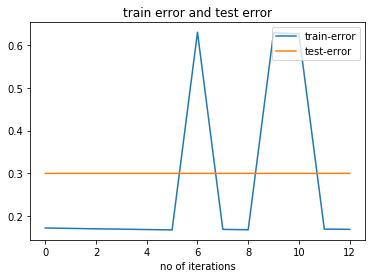

PRECISION: 0.7126436781609196
RECALL: 1.0
F1-SCORE: 0.8322147651006712


In [76]:
model4=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-6)
model4.Train_Test_compare(Liver_train,y_train,Liver_test,y_test,decay="step-decay",optimisation_method="SGD",decay_rate=0.1)
model4.convergence_curve()
model4.performance_measures(Liver_test,y_test)

### MODEL :5
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer : VANILLA STOCHASTIC GD OPTIMISATION
- decay type : exponential
- decay rate :0.1

The number of iterations required for convergence is: 15
The Training-loss at final epoch is: 0.6224763737539944
The Testing-loss at final epoch is: 0.2998158479265437


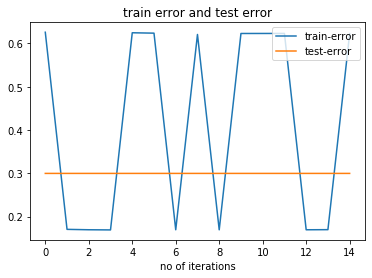

PRECISION: 0.7126436781609196
RECALL: 1.0
F1-SCORE: 0.8322147651006712


In [77]:
model5=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-10)
model5.Train_Test_compare(Liver_train,y_train,Liver_test,y_test,decay="exponential",optimisation_method="SGD",decay_rate=0.1)
model5.convergence_curve()
model5.performance_measures(Liver_test,y_test)

### MODEL :10
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :  SGD WITH MOMENTUM
- beta = 0.9

The number of iterations required for convergence is: 842
The Training-loss at final epoch is: 0.3208275758154511
The Testing-loss at final epoch is: 0.2998638877975382


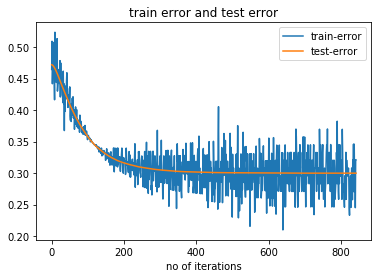

PRECISION: 0.7126436781609196
RECALL: 1.0
F1-SCORE: 0.8322147651006712


In [159]:
model10=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-8)
model10.Train_Test_compare(Liver_train,y_train,Liver_test,y_test,optimisation_method="SGD with momentum")
model10.convergence_curve()
model10.performance_measures(Liver_test,y_test)

### MODEL :11
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :   Ada Grad 

The number of iterations required for convergence is: 249
The Training-loss at final epoch is: 0.2734615097459118
The Testing-loss at final epoch is: 0.30021103614102257


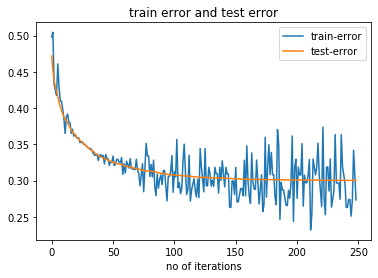

PRECISION: 0.7126436781609196
RECALL: 1.0
F1-SCORE: 0.8322147651006712


In [103]:
model11=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-6)
model11.Train_Test_compare(Liver_train,y_train,Liver_test,y_test,optimisation_method="Ada Grad")
model11.convergence_curve()
model11.performance_measures(Liver_test,y_test)

### MODEL :12
### DESCRIPTION :
- LEARNING RATE =0.01
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :   RMS prop
- beta = 0.9

The number of iterations required for convergence is: 331
The Training-loss at final epoch is: 0.25735715053780134
The Testing-loss at final epoch is: 0.29986986052489334


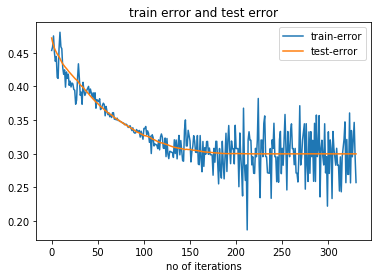

PRECISION: 0.7126436781609196
RECALL: 1.0
F1-SCORE: 0.8322147651006712


In [56]:
model12=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-7)
model12.Train_Test_compare(Liver_train,y_train,Liver_test,y_test,optimisation_method="RMS prop")
model12.convergence_curve()
model12.performance_measures(Liver_test,y_test)

### MODEL :13
### DESCRIPTION :
- LEARNING RATE =0.001
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :   Adam
- beta1 = 0.9
- beta2 = 0.999

The number of iterations required for convergence is: 1160
The Training-loss at final epoch is: 0.23541903331325142
The Testing-loss at final epoch is: 0.2747933350811163


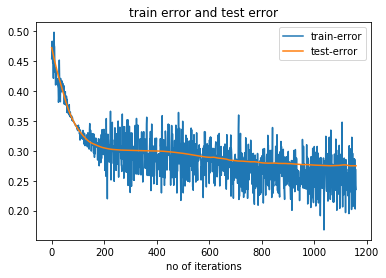

PRECISION: 0.7126436781609196
RECALL: 1.0
F1-SCORE: 0.8322147651006712


In [58]:
model13=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-7)
model13.Train_Test_compare(Liver_train,y_train,Liver_test,y_test,optimisation_method="Adam")
model13.convergence_curve()
model13.performance_measures(Liver_test,y_test)

### MODEL :14
### DESCRIPTION :
- LEARNING RATE =0.001
- $\lambda$(regularisation parameter) = 0
- maximum iterartions = 2000
- optimizer :  Nadam
- beta1 = 0.9
- beta2 = 0.999

The number of iterations required for convergence is: 155
The Training-loss at final epoch is: 0.33105079961031314
The Testing-loss at final epoch is: 0.29999438661737726


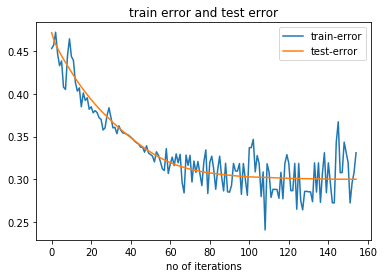

PRECISION: 0.7126436781609196
RECALL: 1.0
F1-SCORE: 0.8322147651006712


In [62]:
model14=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-7)
model14.Train_Test_compare(Liver_train,y_train,Liver_test,y_test,optimisation_method="Nadam")
model14.convergence_curve()
model14.performance_measures(Liver_test,y_test)

# DATASET:3-MULTI-CLASS CLASSIFICATION

## Predict flower type of the Iris plant species

### DESCRIPTION:

#### Instances: 150

#### Attributes: 5

#### flower	string	Nominal: Iris Setosa, Iris Versicolour, Iris Virginica. This is the predictor class

In [5]:
Iris =pd.read_csv('iris_dataset.csv')
Iris.head()

,sepal_length,sepal_width,petal_length,petal_width,flower
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
Iris['flower'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [7]:
dictionary = {"Iris-setosa" :0,'Iris-versicolor':1, 'Iris-virginica':2}
Iris['flower']=Iris['flower'].map(dictionary)
Iris.head()

,sepal_length,sepal_width,petal_length,petal_width,flower
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [8]:
from sklearn.model_selection import train_test_split
X =  Iris.drop('flower', axis=1)
y =  Iris['flower']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
Iris_train= X_train.to_numpy()
Iris_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [14]:
NN_config =[4,6,3]
np.random.seed(10)
W1 = np.random.rand(6,4)
W2 = np.random.rand(3,6)
b1 = np.random.rand(6)
b2 = np.random.rand(3)

The number of iterations required for convergence is: 2000
The Training-loss at final epoch is: 0.3660929945964881
The Testing-loss at final epoch is: 0.3661314432874528


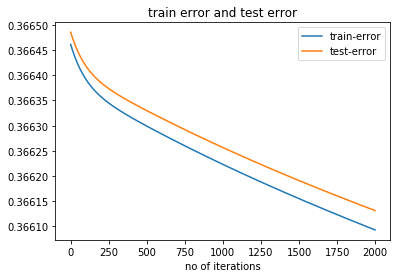

PRECISION: 0.5
RECALL: 1.0
F1-SCORE: 0.6666666666666666


In [179]:
model0=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-7)
model0.Train_Test_compare(Iris_train,y_train,Iris_test,y_test,optimisation_method="BGD")
model0.convergence_curve()

The number of iterations required for convergence is: 2000
The Training-loss at final epoch is: 0.3906143478116868
The Testing-loss at final epoch is: 0.366584143327732


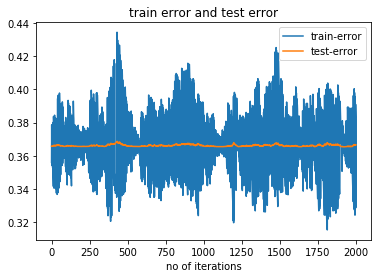

PRECISION: 0.3333333333333333
RECALL: 1.0
F1-SCORE: 0.5


In [183]:
model2=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-9)
model2.Train_Test_compare(Iris_train,y_train,Iris_test,y_test,optimisation_method="SGD")
model2.convergence_curve()

The number of iterations required for convergence is: 1666
The Training-loss at final epoch is: 0.2795470086303492
The Testing-loss at final epoch is: 0.18525800277797735


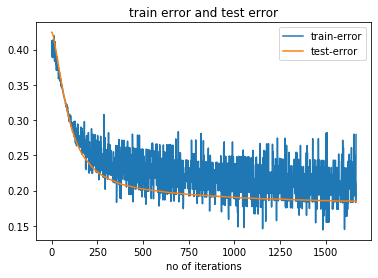

PRECISION: 0.8
RECALL: 1.0
F1-SCORE: 0.888888888888889


In [66]:
model10=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-8)
model10.Train_Test_compare(Iris_train,y_train,Iris_test,y_test,optimisation_method="SGD with momentum")
model10.convergence_curve()

The number of iterations required for convergence is: 2000
The Training-loss at final epoch is: 0.21238135382088572
The Testing-loss at final epoch is: 0.20864331730814842


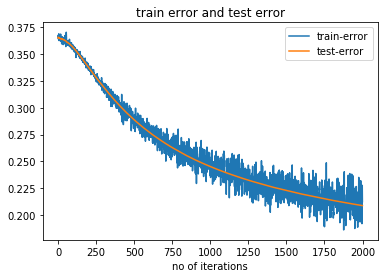

PRECISION: 1.0
RECALL: 1.0
F1-SCORE: 1.0


In [185]:
model11=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-5)
model11.Train_Test_compare(Iris_train,y_train,Iris_test,y_test,optimisation_method="Ada Grad")
model11.convergence_curve()

The number of iterations required for convergence is: 2000
The Training-loss at final epoch is: 0.16216299215903954
The Testing-loss at final epoch is: 0.17306857994660577


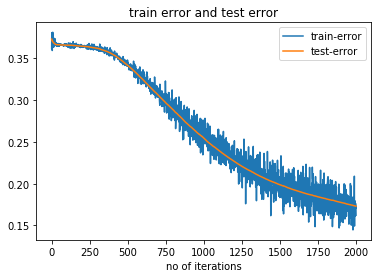

PRECISION: 1.0
RECALL: 1.0
F1-SCORE: 1.0


In [37]:
model12=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=2000,epsilon=1e-7)
model12.Train_Test_compare(Iris_train,y_train,Iris_test,y_test,optimisation_method="RMS prop",batch_size=20)
model12.convergence_curve()

The number of iterations required for convergence is: 73
The Training-loss at final epoch is: 0.36570046960895713
The Testing-loss at final epoch is: 0.3660433907419624


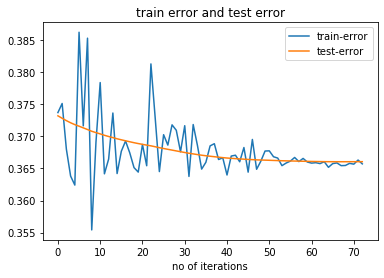

CONFUSION MATRIX:


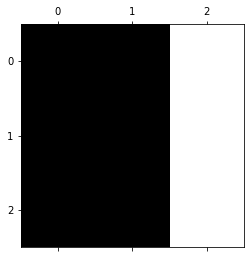

In [13]:
model13=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=800,epsilon=1e-6)
model13.Train_Test_compare(Iris_train,y_train,Iris_test,y_test,optimisation_method="Adam",batch_size=36)
model13.convergence_curve()
model13.confusion_matrix(Iris_test,y_test)

The number of iterations required for convergence is: 33
The Training-loss at final epoch is: 0.3653338335978647
The Testing-loss at final epoch is: 0.36605512233350984


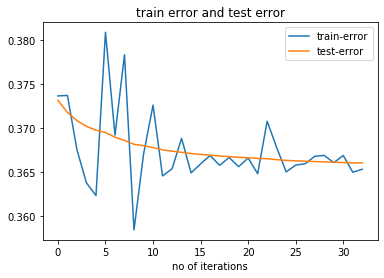

CONFUSION MATRIX:


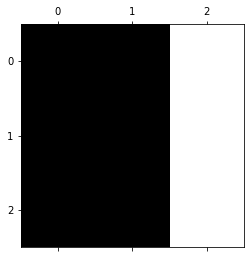

In [15]:
model14=ThreeLayerNN(NN_config,W1,W2,b1,b2,noiter=800,epsilon=1e-5)
model14.Train_Test_compare(Iris_train,y_train,Iris_test,y_test,optimisation_method="Nadam")
model14.convergence_curve()
model14.confusion_matrix(Iris_train,y_train)